### Lorentz System

$\frac{\mathrm{d}x}{\mathrm{d}t} = \sigma (y - x), \\[6pt]$


$\frac{\mathrm{d}y}{\mathrm{d}t} = x (\rho - z) - y, \\[6pt]$


$\frac{\mathrm{d}z}{\mathrm{d}t} = x y - \beta z.$

$σ = 10$, $β = 8/3$ and $ρ = 28$

In [22]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
from matplotlib import pyplot as plt

ImportError: cannot import name 'grad' from 'autograd' (c:\Users\zheyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\autograd\__init__.py)

### Activation Functions

In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))


def elu(z, alpha: float):
    return alpha * (np.exp(z) - 1) if z < 0 else z

### Trial Solution

In [13]:
def trial_solution(
    input: np.array, parameters: list, initial_conditions: np.array
) -> np.array:
    return np.linspace(initial_conditions, initial_conditions, input.size).T + input * forward_propogation(input, parameters)


def right_hand_side(
    input: np.array, trial_sol: np.array, constants: np.array
) -> np.array:
    return np.array(
        [
            constants[0] * (trial_sol[1] - trial_sol[0]),
            trial_sol[0] * (constants[2] - trial_sol[2]) - trial_sol[1],
            trial_sol[0] * trial_sol[1] - constants[1] * trial_sol[2],
        ]
    )

### Loss Function

In [14]:
def MSE_loss_function(
    input, parameters: list, constants: np.array, initial_conditions: np.array
):
    trial_sol = trial_solution(input, parameters, initial_conditions)
    prediction = right_hand_side(input, trial_sol, constants)
    # NaN
    neural_network_gradient = elementwise_grad(trial_solution, 0)(
        input, parameters, initial_conditions
    )

    error_squared = (neural_network_gradient - prediction) ** 2
    error_squared = error_squared / np.size(error_squared)
    loss_sum_mean = np.sum(error_squared)

    return loss_sum_mean

### Neural Network

![](NN.png "Neural Network")

In [15]:
def init_parameters(input_size: int, hidden_sizes: np.array, output_size: int):
    np.random.seed(0)
    parameters = [None] * (hidden_sizes.shape[0] + 1) # +1 for the output

    # hidden weights and biases
    parameters[0] = np.random.randn(hidden_sizes[0], input_size + 1)
    for i in range(1, hidden_sizes.shape[0]):
        parameters[i] = np.random.randn(hidden_sizes[i], hidden_sizes[i - 1] + 1) # +1 for the bias

    # output weights and biases
    parameters[-1] = np.random.randn(output_size, hidden_sizes[-1] + 1) # +1 for the bias

    return parameters

In [16]:
def forward_propogation(input: np.array, parameters: list):
    num_hidden_layers = len(parameters) - 1
    num_inputs = input.size
    input = input.reshape(-1, input.size)

    # hidden layers
    z = np.matmul(parameters[0], np.concatenate((np.ones((1, num_inputs)), input), axis = 0))
    a = sigmoid(z)
    for i in range(1, num_hidden_layers):
        z = np.matmul(parameters[i], np.concatenate((np.ones((1, num_inputs)), a), axis = 0))
        a = sigmoid(z)

    # output layer
    z = np.matmul(parameters[-1], np.concatenate((np.ones((1, num_inputs)), a), axis = 0))
    
    return z

In [17]:
parameters = init_parameters(1, np.array([1]), 1)
print(parameters)
forward = forward_propogation(np.array([2]), parameters)
print(forward)

[array([[1.76405235, 0.40015721]]), array([[0.97873798, 2.2408932 ]])]
[[3.05948077]]


In [18]:
def gradient_descent(
    input: np.array,
    parameters: list,
    constants: np.array,
    initial_conditions: np.array,
    num_iter: int,
    learn_rate: float,
):
    loss_grad_function = grad(MSE_loss_function, 1)

    for i in range(num_iter):
        print(MSE_loss_function(input, parameters, constants, initial_conditions))
        loss_grad = loss_grad_function(input, parameters, constants, initial_conditions)
        # print(loss_grad)
        # hidden layers
        for j in range(len(parameters)):
            parameters[j] = parameters[j] - learn_rate * loss_grad[j]

    return parameters

In [19]:
t = np.arange(0, 10, 0.01, dtype=np.longdouble)
constants = np.array([10.0, 8 / 3, 28.0])
initial_conditions = np.array([0.0, 1.0, 1.05])
num_iter = 100000
learn_rate = 0.0000002

parameters = init_parameters(1, np.array([50, 50, 50]), 3)
parameters = gradient_descent(
    t, parameters, constants, initial_conditions, num_iter, learn_rate
)
res = trial_solution(t, parameters, initial_conditions)
print(res)

NameError: name 'grad' is not defined

In [2]:
def adam(input, parameters, constants, initial_conditions, grad, num_iters=10000,
         step_size=0.001, b1=0.9, b2=0.999, eps=10**-8):
    m = [np.zeros(parameters[i].size) for i in range(len(parameters))]
    v = [np.zeros(parameters[i].size) for i in range(len(parameters))]
    mhat = [None] * len(parameters)
    vhat = [None] * len(parameters)
    for i in range(num_iters):
        g = grad(input, parameters, constants, initial_conditions)
        for j in range(len(parameters)):
            m[j] = (1 - b1) * g[j]      + b1 * m[j]  # First  moment estimate.
            v[j] = (1 - b2) * (g[j]**2) + b2 * v[j]  # Second moment estimate.
            mhat[j] = m[j] / (1 - b1**(i + 1))    # Bias correction.
            vhat[j] = v[j] / (1 - b2**(i + 1))
            parameters[j] = parameters[j] - step_size * mhat[j]/(np.sqrt(vhat[j]) + eps)
    
    return parameters

In [3]:
t = np.arange(0, 10, 0.01, dtype=np.longdouble)
constants = np.array([10.0, 8 / 3, 28.0])
initial_conditions = np.array([0.0, 1.0, 1.05])
num_iter = 10000
learn_rate = 0.001
parameters = init_parameters(1, np.array([50, 50, 50]), 3)

loss_grad_function = grad(MSE_loss_function, 1)
parameters = adam(t, parameters, constants, initial_conditions, loss_grad_function)

res = trial_solution(t, parameters, initial_conditions)
print(res)

NameError: name 'np' is not defined

[[ 0.00000000e+00  1.32157098e-02  2.61627335e-02 ... -8.59930007e+00
  -8.60128911e+00 -8.60328881e+00]
 [ 1.00000000e+00  9.95332761e-01  9.90667237e-01 ... -8.29872428e+00
  -8.29789507e+00 -8.29706771e+00]
 [ 1.05000000e+00  1.08568141e+00  1.12169068e+00 ...  2.77742273e+01
   2.77826398e+01  2.77910781e+01]]


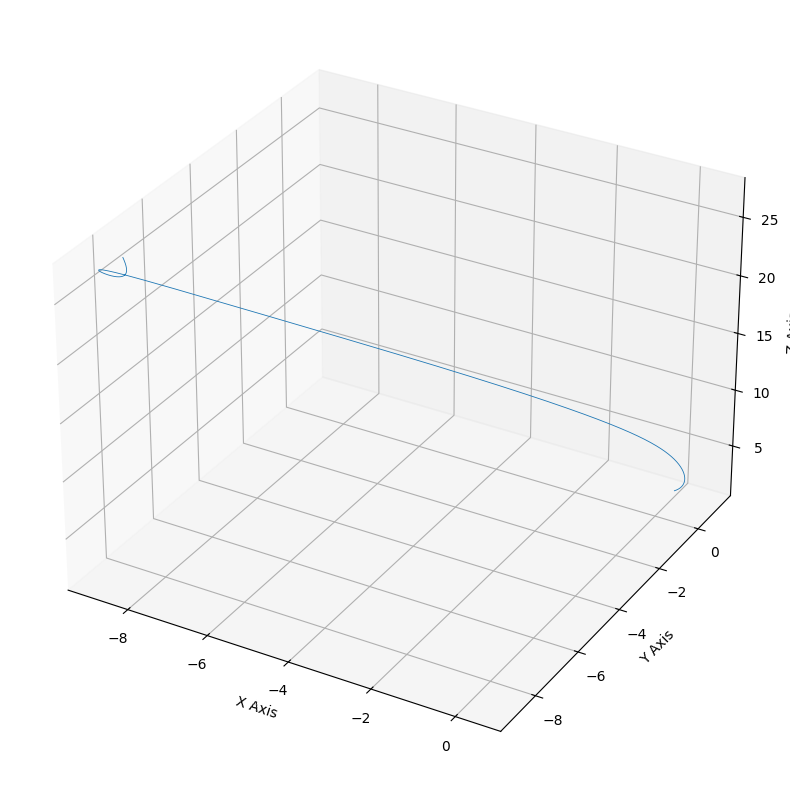

In [436]:
'''
with np.printoptions(threshold=np.inf):
    print(res)
'''
print(res)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.plot(res[0], res[1], res[2], lw=0.6)

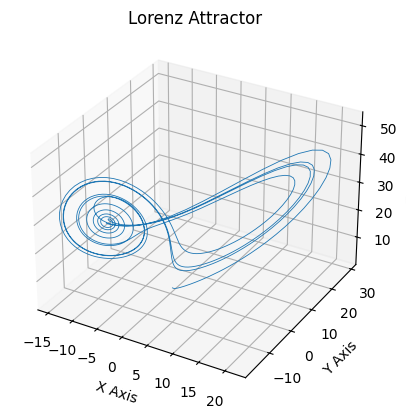

In [189]:
def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s * (y - x)
    y_dot = r * x - y - x * z
    z_dot = x * y - b * z
    return np.array([x_dot, y_dot, z_dot])

dt = 0.01
num_steps = 999

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = [0.0, 1.0, 1.05]  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
ax.plot(*xyzs.T, lw=0.6)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()